In [1]:
import matplotlib.pyplot as plt
from src.csm_dp import * # this does "import numpy as np" too
#from scipy.optimize import root_scalar
#from scipy.integrate import quad
#import vegas
#import sys
from scipy.integrate import cumulative_trapezoid
#import time
sigma_SB = 5.67e-5 # erg/cm^2/s/K^4
M_sun = 1.9891e30 # solar mass in kg
yr2s = 31556926 # year in seconds

def planck_spectral_radiance(wavelength_nm, T):
    """
    Planck's Law: B_lambda(lambda, T)
    Units: W / (m^2 * nm)
    """
    # Constants
    h = 6.62607015e-34  # Planck constant (J*s)
    c = 299792458       # Speed of light (m/s)
    k = 1.380649e-23    # Boltzmann constant (J/K)
    
    lam = wavelength_nm * 1e-9 # Convert nm to meters
    exponent = (h * c) / (lam * k * T)
    
    # Avoid overflow in exp
    if exponent > 700:
        return 0.0
    
    numerator = 2 * h * c**2
    denominator = lam**5 * (np.exp(exponent) - 1)
    
    return numerator / denominator * 1e-9 # Result in W/(m^2 * nm)

def calculate_eta(T, blue_limit=400, red_limit=900):
    """
    Calculates the fraction of total energy within the specified band.
    """
    # Integrate within the band (400nm to 900nm)
    band_energy, _ = quad(planck_spectral_radiance, blue_limit, red_limit, args=(T,))
    
    # Total bolometric energy (Stefan-Boltzmann Law equivalent integration)
    # Using a very wide range to approximate 0 to infinity
    total_energy, _ = quad(planck_spectral_radiance, 0.001, 1e6, args=(T,))
    return band_energy / total_energy

temperature_list = np.logspace(3,5,30)
eta_list = [calculate_eta(T) for T in temperature_list]

iota_interp = interp1d(np.log10(temperature_list),np.log10(eta_list))

def iota(T):
    try:
        logT = np.log10(T)
        iota = 10**iota_interp(logT)
    except:
        iota = calculate_eta(T)
    return iota

/var/folders/0d/rwlphr1x0sq99kpyh_g1pw8h0000gn/T/ipykernel_96329/1377442275.py:44: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  total_energy, _ = quad(planck_spectral_radiance, 0.001, 1e6, args=(T,))


In [2]:
SN_name = 'SN 2023ixf'
SN_profile = 'LS220' # 'SFHo' or 'TF'
CSM_radius = np.logspace(np.log10(5e13),np.log10(5e15),100) # default 50

interp_u = True # use look up table for internal function
eps_val = 1.5e-13
mAp_val = 20

for eps in [eps_val]: # eps_list
    FBB_list = [] # for BB luminosity storage
    TBB_list = [] # ...    temperature ...
    RBB_list = [] # ...    radius      ...
    TAU_list = [] # ...    average tau ...
    GAS_TEMP_AT_1E15 = [] # for gas temp at 1e15 cm storage
    GAS_TEMP_AT_2E15 = [] # ...             2e15 ...
    GAS_TEMP_AT_3E15 = [] # ...             3e15 ...
    GAS_TEMP_AT_4E15 = [] # ...             4e15 ...
    for mAp in [mAp_val]: # mAp_list
        # creat empty list to store data
        T_wt_rad = [] # empty list to store temperature at different CSM radius with radiation in LTE
        T_wo_rad = [] # ...                                                     without radiation in LTE
        avg_time = average_stopping_time(eps,mAp,CSM_radius,SN_profile=SN_profile) # get average stopping time at different CSM radius
        avg_eff = average_efficiency(eps,mAp,CSM_radius,SN_profile=SN_profile)     # get average energy deposition efficiency at different CSM radius
        avg_eff[avg_eff > 1] = 1 # make sure efficiency cannot exceed 1
        avg_eff[avg_eff < 0] = 0 # ...                         below 0

        Q_dot = dQ_dV(CSM_radius,eps,mAp,SN_profile=SN_profile) * avg_eff / avg_time # energy deposition rate at different CSM radius
        
        for i in range(len(CSM_radius)):
            r = CSM_radius[i]
            # Get temperature with radiation in LTE
            try:
                T_rad,_,_ = get_T(r,eps,mAp,SN_name=SN_name,SN_profile=SN_profile,efficiency=avg_eff[i],interp_u=interp_u)
            except:
                # check the solver fails at this point is due to dQ is too small to raise any temperature or too large that breaks the upper bracket
                if dQ_dV(r,eps,mAp,SN_name=SN_name,SN_profile=SN_profile) <= 1e-2: # dQ_dV is too low to raise meaningful T
                    T_rad = 1 # Let it truncates at 1 K
                else:
                    T_rad = np.nan # fail to find solution
            T_wt_rad.append(T_rad)
            
            # Get gas only temperature, not in LTE (radiation is not included)
            try:
                T_norad,_,_ = get_T(r,eps,mAp,SN_name=SN_name,SN_profile=SN_profile,include_rad=False,efficiency=avg_eff[i],interp_u=interp_u)
            except:
                # check the solver fails at this point is due to dQ is too small to raise any temperature or too large that breaks the upper bracket
                if dQ_dV(r,eps,mAp,SN_name=SN_name,SN_profile=SN_profile) <= 1e-2:
                    T_norad = 1 # Let it truncates at 1 K
                else:
                    T_norad = np.nan # fail to find solution
            T_wo_rad.append(T_norad)

        # Get optical depth
        rho = CSM_density(CSM_radius,SN_name=SN_name)
        dtau = kappa(rho,T_wt_rad) * rho # opacity * density
        # if dtau is nan, that means it is beyond the valid range of Ferguson/OPAL tables, this happens when T < 600 K
        # this means the gas becomes transparent, thus make dtau 0
        dtau[np.isnan(dtau)] = 0
        # calculate average tau at different CSM radius
        int_0_to_i = cumulative_trapezoid(dtau, CSM_radius, initial=0)
        total_integral = int_0_to_i[-1]
        opt_depth = total_integral - int_0_to_i
        opt_depth[opt_depth < 1e-20] = 1e-20 # average to small or negative, truncate it at 1e-20 to avoid numerical error for later use
        
        # Get the photosphere radius
        r_photo = 10**np.interp(np.log10(2/3),np.log10(opt_depth[:-1])[::-1],np.log10(CSM_radius[:-1])[::-1], left=np.nan, right=np.nan)
        if np.isnan(r_photo) is not True:
            # r_photo exists
            # Get the photosphere temperature
            T_photo = 10**np.interp(np.log10(r_photo),np.log10(CSM_radius[:-1]),np.log10(T_wt_rad[:-1]), left=np.nan, right=np.nan)
        else: # r_photo does not exist
            T_photo = np.nan
        
        # Get the blackbody radiation at surface
        if np.isnan(r_photo) is not True:
            F_BB = 4 * np.pi * r_photo**2 * sigma_SB * T_photo**4 * iota(T_photo)
        else:
            F_BB = np.nan
        
        # Get average tau before r_photo
        R_to_photo = np.append(CSM_radius[CSM_radius < r_photo], r_photo)
        tau_to_photo = np.append(opt_depth[CSM_radius < r_photo], 2/3)
        # Get the area and perform trapozoidial integration
        area = np.trapz(tau_to_photo, R_to_photo)
        avg_tau = area / (R_to_photo.max() - R_to_photo.min())

        # Get cooling rate
        cool_rate = CSM_radiative_cooling_rate(CSM_radius,5000)
        cool_rate[CSM_radius > r_photo] = CSM_radiative_cooling_rate(CSM_radius,T_wo_rad)[CSM_radius > r_photo]

Text(0, 0.5, '$T$ [K]')

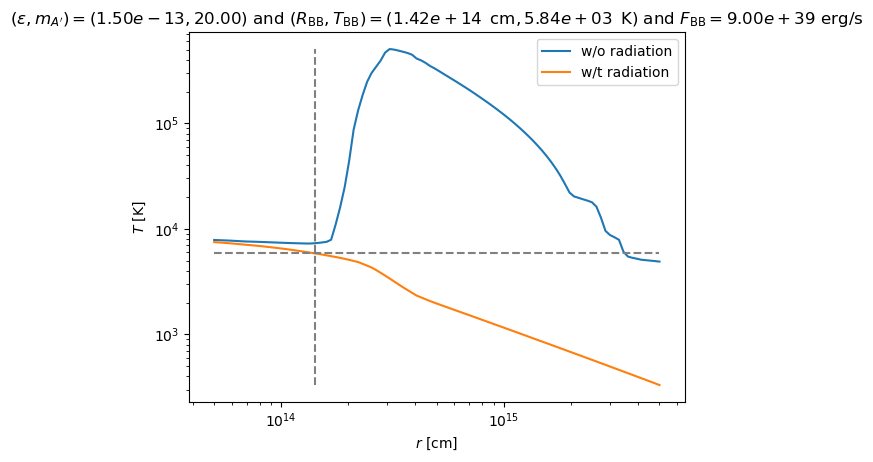

In [3]:
plt.plot(CSM_radius,T_wo_rad,label='w/o radiation')
plt.plot(CSM_radius,T_wt_rad,label='w/t radiation')
if np.isnan(r_photo) is not True:
    # r_photo exists, corresponds to tau = 2/3
    plt.plot([r_photo,r_photo],[min(T_wt_rad),max(T_wo_rad)],'--',color='gray')
    plt.plot([CSM_radius[0],CSM_radius[-1]],[T_photo,T_photo],'--',color='gray')

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlim(CSM_radius[0]/1.3,CSM_radius[-1]*1.3)
plt.title(fr'$(\epsilon,m_{{A^\prime}})=({eps:.2e},{mAp:.2f})$ and $(R_{{\rm BB}},T_{{\rm BB}})=({r_photo:.2e}{{\rm~\,cm}},{T_photo:.2e}{{\rm~\,K}})$ and $F_{{\rm BB}}={F_BB:.2e}$ erg/s')
plt.xlabel(r'$r$ [cm]')
plt.ylabel(r'$T$ [K]')

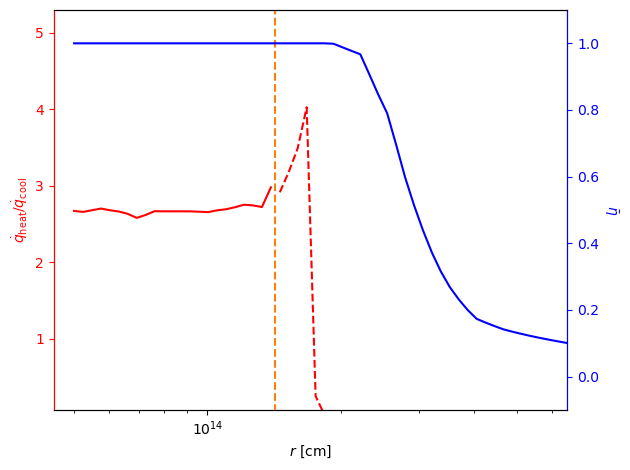

In [4]:
# 2. 建立畫布與第一個座標軸 (ax1)
fig, ax1 = plt.subplots()

color = 'red'
ax1.set_xlabel(r'$r$ [cm]')
ax1.set_ylabel(r'$\dot{q}_{\rm heat}/\dot{q}_{\rm cool}$', color=color)
ax1.plot(CSM_radius[CSM_radius <= r_photo],(Q_dot/cool_rate)[CSM_radius <= r_photo],color=color)
ax1.plot(CSM_radius[CSM_radius > r_photo],(Q_dot/cool_rate)[CSM_radius > r_photo],'--',color=color)

ax1.tick_params(axis='y', colors=color) # 讓刻度文字也變綠色

#plt.plot(CSM_radius,cool_rate,color='C0',label='cool')
if np.isnan(r_photo) is not True:
    # r_photo exists, corresponds to tau = 2/3
    ax1.plot([r_photo,r_photo],[-0.1,7.1],'--',color='C1')
ax1.set_xscale('log')
#ax1.set_yscale('log')
ax1.set_ylim(0.07,5.3)
ax1.set_xlim(4.5e13,6.5e14)

# ax1.set_ylim(-0.002,0.062)
# 3. 建立共用 X 軸的第二個座標軸 (ax2)
ax2 = ax1.twinx() 
# 繪製右邊 Y 軸的線條

color2 = 'blue'
ax2.set_ylabel(r'$\bar{\eta}$', color=color2, rotation=270, labelpad=15)
ax2.plot(CSM_radius,avg_eff, color=color2)

#ax2.plot(CSM_radii,Q_mAp_102p32_MeV, color=color2, linestyle='--', linewidth=2)
#ax2.set_yscale('log')
ax2.tick_params(axis='y', which='both', colors=color2) 
ax2.spines['left'].set_color(color)
ax2.spines['right'].set_color(color2)
ax2.set_ylim(-0.1,1.1)

#ax2.text(2e15,3.2e49,r'$m_{A^\prime}=10.47$ MeV',fontsize=10,color=color2)
#ax2.text(2e15,3.2e47,r'$m_{A^\prime}=102.32$ MeV',fontsize=10,color=color2)

# 4. 調整佈局並顯示
fig.tight_layout()
#plt.legend()
#plt.savefig(r'ratio_eff.pdf',bbox_inches='tight')

In [5]:
Temp_list = np.logspace(3,4.5,500)
kappa_avg_rho = [kappa(2e-12,T) for T in Temp_list]

Text(0, 0.5, '$\\kappa$ [cm$^2$ g$^{-1}$]')

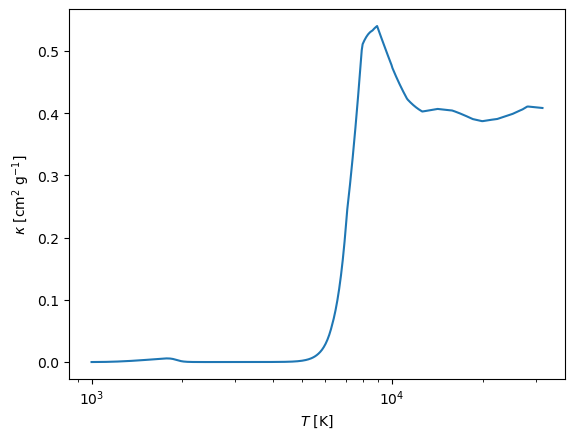

In [6]:
plt.plot(Temp_list,kappa_avg_rho)
#plt.plot(T_list,kappa_small_rho)
plt.xscale('log')
#plt.yscale('log')
plt.xlabel(r'$T$ [K]')
plt.ylabel(r'$\kappa$ [cm$^2$ g$^{-1}$]')
#plt.savefig('kappa.pdf',bbox_inches='tight')